# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

## Подготовка данных

### Открытие и изучение файлов

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from collections import defaultdict
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor

In [2]:
RANDOM_STATE = 12345

In [3]:
gold_recovery_train = pd.read_csv('datasets/gold_recovery_train_new.csv')
display(gold_recovery_train.info())
display(gold_recovery_train.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


None

(14149, 87)

In [4]:
gold_recovery_test = pd.read_csv('datasets/gold_recovery_test_new.csv')
display(gold_recovery_test.info())
display(gold_recovery_test.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

None

(5290, 53)

In [5]:
gold_recovery_full = pd.read_csv('datasets/gold_recovery_full_new.csv')
display(gold_recovery_full.info())
display(gold_recovery_full.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


None

(19439, 87)

### Проверка рассчетов эффективности обогащения. Вычисление на обучающей выборке для признака rougher.output.recovery. Вычисление MAE между расчётами и значением признака.

In [6]:
C = gold_recovery_train['rougher.output.concentrate_au']
F = gold_recovery_train['rougher.input.feed_au']
T = gold_recovery_train['rougher.output.tail_au']
output_recovery = gold_recovery_train['rougher.output.recovery']
calculated_recovery = C * (F - T) / F/ (C - T) * 100
print('MAE =', mean_absolute_error(output_recovery, calculated_recovery))

MAE = 1.0748911125799084e-14


**MAE очень мала, соответственно, recovery посчитан верно**

### Анализ признаков, недоступных в тестовой выборке. 

In [7]:
gold_recovery_test_columns = list(gold_recovery_train.columns.difference(gold_recovery_test.columns))
gold_recovery_test_columns

['final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

В тестовой выборке отсутствуют столбцы с признаками .output и .calculation.

Это онлайн метрики. Они будут получены по результатам технологического процесса.

### Предобработка данных

Посмотрим на количество пропусков в данных

In [8]:
gold_recovery_train.isna().sum()

date                                            0
final.output.concentrate_ag                     1
final.output.concentrate_pb                     1
final.output.concentrate_sol                  211
final.output.concentrate_au                     0
                                             ... 
secondary_cleaner.state.floatbank5_a_level      1
secondary_cleaner.state.floatbank5_b_air        1
secondary_cleaner.state.floatbank5_b_level      1
secondary_cleaner.state.floatbank6_a_air        2
secondary_cleaner.state.floatbank6_a_level      1
Length: 87, dtype: int64

In [9]:
gold_recovery_test.isna().sum()

date                                           0
primary_cleaner.input.sulfate                  4
primary_cleaner.input.depressant               5
primary_cleaner.input.feed_size                0
primary_cleaner.input.xanthate                 4
primary_cleaner.state.floatbank8_a_air         0
primary_cleaner.state.floatbank8_a_level       0
primary_cleaner.state.floatbank8_b_air         0
primary_cleaner.state.floatbank8_b_level       0
primary_cleaner.state.floatbank8_c_air         0
primary_cleaner.state.floatbank8_c_level       0
primary_cleaner.state.floatbank8_d_air         0
primary_cleaner.state.floatbank8_d_level       0
rougher.input.feed_ag                          0
rougher.input.feed_pb                          0
rougher.input.feed_rate                        3
rougher.input.feed_size                        1
rougher.input.feed_sol                        21
rougher.input.feed_au                          0
rougher.input.floatbank10_sulfate              5
rougher.input.floatb

In [10]:
gold_recovery_full.isna().sum()

date                                            0
final.output.concentrate_ag                     1
final.output.concentrate_pb                     1
final.output.concentrate_sol                  211
final.output.concentrate_au                     0
                                             ... 
secondary_cleaner.state.floatbank5_a_level      1
secondary_cleaner.state.floatbank5_b_air        1
secondary_cleaner.state.floatbank5_b_level      1
secondary_cleaner.state.floatbank6_a_air        2
secondary_cleaner.state.floatbank6_a_level      1
Length: 87, dtype: int64

Удаление пропусков

In [11]:
gold_recovery_test = gold_recovery_test.dropna()
gold_recovery_train = gold_recovery_train.dropna()
gold_recovery_full = gold_recovery_full.dropna()

Удалим околонулевые значения

In [12]:
gold_recovery_train = gold_recovery_train.drop(gold_recovery_train[gold_recovery_train['final.output.concentrate_au'] < 1].index)
gold_recovery_train = gold_recovery_train.drop(gold_recovery_train[gold_recovery_train['final.output.concentrate_ag'] < 1].index)
gold_recovery_train = gold_recovery_train.drop(gold_recovery_train[gold_recovery_train['final.output.concentrate_pb'] < 1].index)
gold_recovery_train = gold_recovery_train.drop(gold_recovery_train[gold_recovery_train['final.output.concentrate_sol'] < 1].index)
gold_recovery_train = gold_recovery_train.drop(gold_recovery_train[gold_recovery_train['primary_cleaner.output.concentrate_au'] < 1].index)
gold_recovery_train = gold_recovery_train.drop(gold_recovery_train[gold_recovery_train['primary_cleaner.output.concentrate_ag'] < 1].index)
gold_recovery_train = gold_recovery_train.drop(gold_recovery_train[gold_recovery_train['primary_cleaner.output.concentrate_pb'] < 1].index)
gold_recovery_train = gold_recovery_train.drop(gold_recovery_train[gold_recovery_train['primary_cleaner.output.concentrate_sol'] < 1].index)
gold_recovery_train = gold_recovery_train.drop(gold_recovery_train[gold_recovery_train['rougher.output.concentrate_au'] < 1].index)
gold_recovery_train = gold_recovery_train.drop(gold_recovery_train[gold_recovery_train['rougher.output.concentrate_ag'] < 1].index)
gold_recovery_train = gold_recovery_train.drop(gold_recovery_train[gold_recovery_train['rougher.output.concentrate_pb'] < 1].index)
gold_recovery_train = gold_recovery_train.drop(gold_recovery_train[gold_recovery_train['rougher.output.concentrate_sol'] < 1].index)

### Вывод

- Данные открыты и изучены
- Проверен расчет MAE
- Проверены признаки, недоступные в тестовой выборке
- Удалены пропуски
- Удалены нулевые значения

## Анализ данных

### Изменение концентрация металлов (Au, Ag, Pb) на различных этапах очистки.

#### Концентрация золота

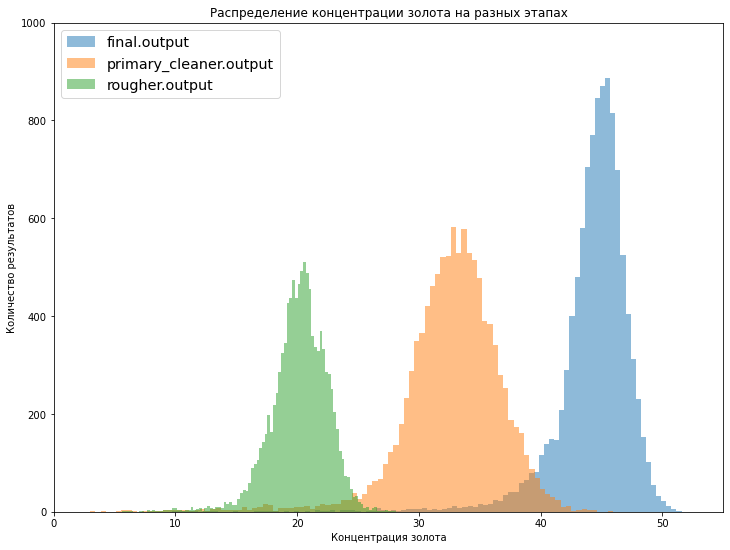

In [13]:
plt.figure(figsize=[12,9])

plt.hist(gold_recovery_train['final.output.concentrate_au'], bins=100, label = 'final.output', alpha=.5)
plt.hist(gold_recovery_train['primary_cleaner.output.concentrate_au'], bins=100, label = 'primary_cleaner.output', alpha=.5)
plt.hist(gold_recovery_train['rougher.output.concentrate_au'], bins=100, label = 'rougher.output', alpha=.5)

plt.xlim([0, 55])
plt.ylim([0, 1000])

plt.xlabel("Концентрация золота")
plt.ylabel("Количество результатов")

plt.legend(loc='upper left', fontsize='x-large')

plt.title("Распределение концентрации золота на разных этапах")
plt.show()

Концентрация золота с каждым этапом повышается, для этого и проводится флотация и очистка

#### Концентрация серебра

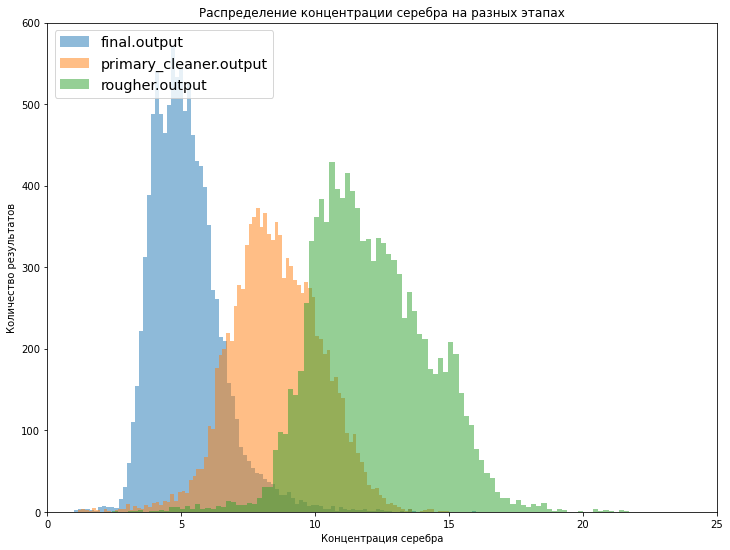

In [14]:
plt.figure(figsize=[12,9])

plt.hist(gold_recovery_train['final.output.concentrate_ag'], bins=100, label = 'final.output', alpha=.5)
plt.hist(gold_recovery_train['primary_cleaner.output.concentrate_ag'], bins=100, label = 'primary_cleaner.output', alpha=.5)
plt.hist(gold_recovery_train['rougher.output.concentrate_ag'], bins=100, label = 'rougher.output', alpha=.5)

plt.xlim([0, 25])
plt.ylim([0, 600])

plt.xlabel("Концентрация серебра")
plt.ylabel("Количество результатов")

plt.legend(loc='upper left', fontsize='x-large')

plt.title("Распределение концентрации серебра на разных этапах")
plt.show()

Концентрация серебра уменьшается с каждым этапом, ведь нужно получить золото

#### Концентрация свинца

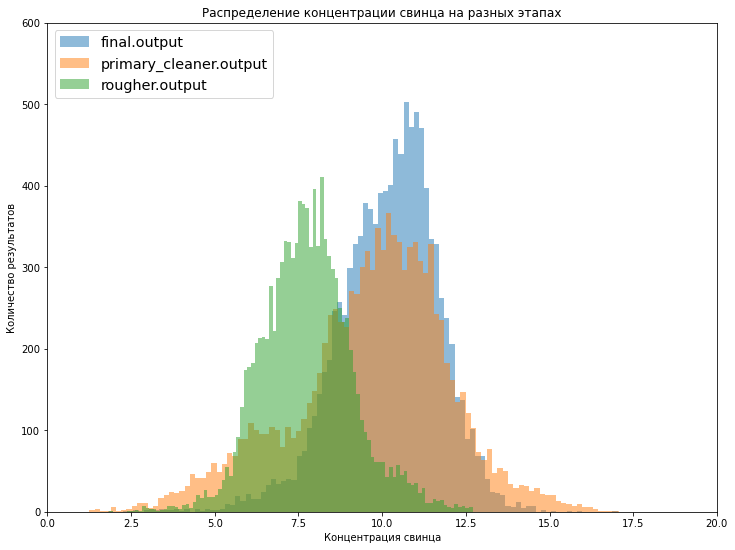

In [15]:
plt.figure(figsize=[12,9])

plt.hist(gold_recovery_train['final.output.concentrate_pb'], bins=100, label = 'final.output', alpha=.5)
plt.hist(gold_recovery_train['primary_cleaner.output.concentrate_pb'], bins=100, label = 'primary_cleaner.output', alpha=.5)
plt.hist(gold_recovery_train['rougher.output.concentrate_pb'], bins=100, label = 'rougher.output', alpha=.5)

plt.xlim([0, 20])
plt.ylim([0, 600])

plt.xlabel("Концентрация свинца")
plt.ylabel("Количество результатов")

plt.legend(loc='upper left', fontsize='x-large')

plt.title("Распределение концентрации свинца на разных этапах")
plt.show()

Концентрация свинца повышается с флотации до первичной очистки, потом усредняется. Свинец является важной составляющей в очистке золота, для грамотного объяснения нужно изучить разные методы очистки, которые используют свинец (например купелирование)

### Распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

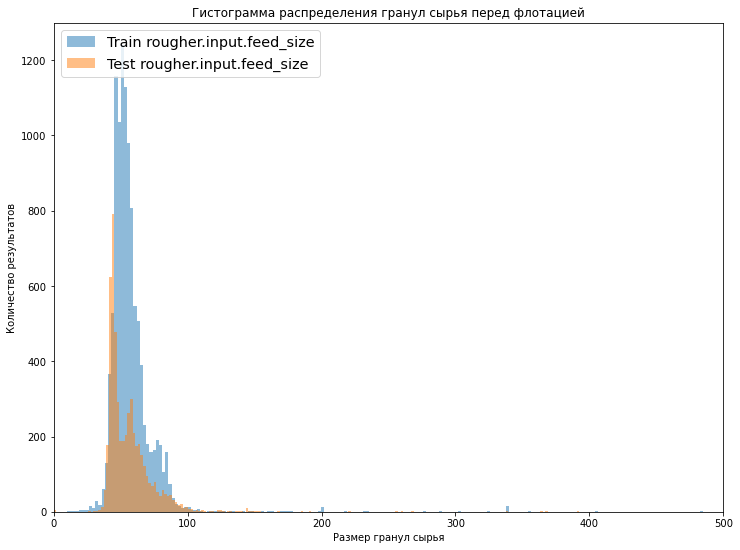

In [16]:
plt.figure(figsize=[12,9])

plt.hist(gold_recovery_train['rougher.input.feed_size'], bins=200, label = 'Train rougher.input.feed_size', alpha=.5)
plt.hist(gold_recovery_test['rougher.input.feed_size'], bins=200, label = 'Test rougher.input.feed_size', alpha=.5)

plt.xlim([0, 500])
plt.ylim([0, 1300])

plt.xlabel("Размер гранул сырья")
plt.ylabel("Количество результатов")

plt.legend(loc='upper left', fontsize='x-large')

plt.title("Гистограмма распределения гранул сырья перед флотацией")
plt.show()

Распределения не отличаются друг от друга

### Суммарная концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

Подготовка столбцов

In [17]:
final_output_concentrate = (gold_recovery_train['final.output.concentrate_au'] + 
                                      gold_recovery_train['final.output.concentrate_ag'] + 
                                      gold_recovery_train['final.output.concentrate_pb'] +
                                      gold_recovery_train['final.output.concentrate_sol'])
primary_cleaner_output = (gold_recovery_train['primary_cleaner.output.concentrate_au'] + 
                                                gold_recovery_train['primary_cleaner.output.concentrate_ag'] + 
                                                gold_recovery_train['primary_cleaner.output.concentrate_pb'] +
                                                gold_recovery_train['primary_cleaner.output.concentrate_sol'])
rougher_output_concentrate = (gold_recovery_train['rougher.output.concentrate_au'] + 
                                        gold_recovery_train['rougher.output.concentrate_ag'] + 
                                        gold_recovery_train['rougher.output.concentrate_pb'] +
                                        gold_recovery_train['rougher.output.concentrate_sol'])

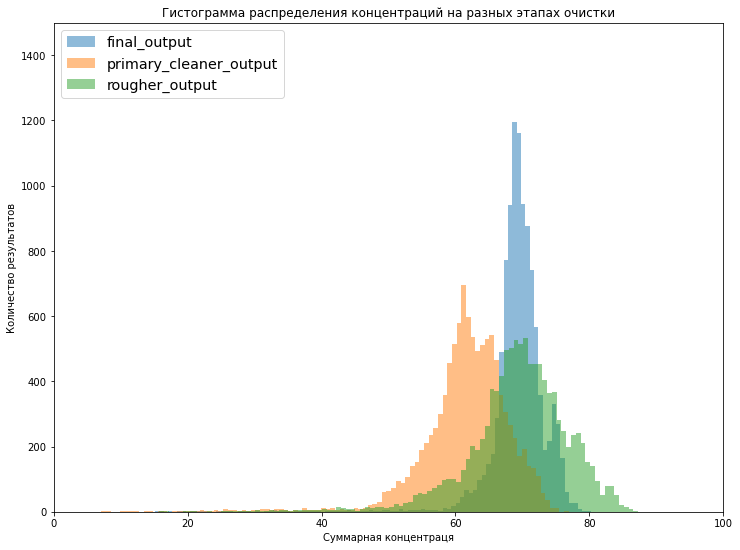

In [18]:
plt.figure(figsize=[12,9])

plt.hist(final_output_concentrate, bins=100, label = 'final_output', alpha=.5)
plt.hist(primary_cleaner_output, bins=100, label = 'primary_cleaner_output', alpha=.5)
plt.hist(rougher_output_concentrate, bins=100, label = 'rougher_output', alpha=.5)

plt.xlim([0, 100])
plt.ylim([0, 1500])

plt.xlabel("Суммарная концентраця")
plt.ylabel("Количество результатов")

plt.legend(loc='upper left', fontsize='x-large')

plt.title("Гистограмма распределения концентраций на разных этапах очистки")
plt.show()

### Вывод

- Изучено изменение концентрации металлов на разных этапах
- Изучено распределение размеров гранул сырья
- Изучена суммарная концентрация всех веществ на разных этапах

## Модель

### Функция для вычисления итоговой sMAPE.

In [19]:
def smape(y, y_pred, **kwargs):
    return (((abs(y - y_pred) * 2 * 100) /
              (abs(y) + abs(y_pred))).sum()) / len(y)

def end_smape(rougher_smape, final_smape):
    return 0.25 * rougher_smape.item() + 0.75 * final_smape.item()

### Обучение разных моделей. 

#### Подготовка данных

In [20]:
cols_for_drop = ['final.output.concentrate_ag',
                        'final.output.concentrate_au',
                        'final.output.concentrate_pb',
                        'final.output.concentrate_sol',
                        'final.output.tail_ag',
                        'final.output.tail_au',
                        'final.output.tail_pb',
                        'final.output.tail_sol',
                        'primary_cleaner.output.concentrate_ag',
                        'primary_cleaner.output.concentrate_au',
                        'primary_cleaner.output.concentrate_pb',
                        'primary_cleaner.output.concentrate_sol',
                        'primary_cleaner.output.tail_ag',
                        'primary_cleaner.output.tail_au',
                        'primary_cleaner.output.tail_pb',
                        'primary_cleaner.output.tail_sol',
                        'rougher.calculation.au_pb_ratio',
                        'rougher.calculation.floatbank10_sulfate_to_au_feed',
                        'rougher.calculation.floatbank11_sulfate_to_au_feed',
                        'rougher.calculation.sulfate_to_au_concentrate',
                        'rougher.output.concentrate_ag',
                        'rougher.output.concentrate_au',
                        'rougher.output.concentrate_pb',
                        'rougher.output.concentrate_sol',
                        'rougher.output.tail_ag',
                        'rougher.output.tail_au',
                        'rougher.output.tail_pb',
                        'rougher.output.tail_sol',
                        'secondary_cleaner.output.tail_ag',
                        'secondary_cleaner.output.tail_au',
                        'secondary_cleaner.output.tail_pb',
                        'secondary_cleaner.output.tail_sol']
gold_recovery_test = gold_recovery_full[gold_recovery_full['date'].isin(gold_recovery_test['date'])]
gold_recovery_test = gold_recovery_test.drop(columns=cols_for_drop)
gold_recovery_train = gold_recovery_train.drop(columns=cols_for_drop)

In [21]:
def feature_target_rougher(data):
    data_cols = pd.Series(data.columns)
    features_1_col = list(data_cols[data_cols.str.contains('rougher.input|rougher.state')])
    features_1 = data[features_1_col]
    
    scaler_1 = StandardScaler()
    features_1 = scaler_1.fit_transform(features_1)
    target_1 = data['rougher.output.recovery']
    
    return features_1, target_1, scaler_1

In [22]:
def feature_target_final(data):
    features_2 = data.drop(['final.output.recovery', 'rougher.output.recovery', 'date'], axis=1)
    
    scaler_2 = StandardScaler()
    features_2 = scaler_2.fit_transform(features_2)
    target_2 = data['final.output.recovery']
    
    return features_2, target_2, scaler_2

In [23]:
def get_cv_scores(model, target, features):
    my_scorer = make_scorer(smape)
    
    scores = cross_val_score(model,
                             features,
                             target,
                             cv=5,
                             scoring=my_scorer)
    
    return scores.mean()

In [24]:
features_1, target_1, scaler_1 = feature_target_rougher(gold_recovery_train)
features_2, target_2, scaler_2 = feature_target_final(gold_recovery_train)

#### Дерево решений

In [25]:
d = defaultdict(list)

for depth in range(2, 14):
    
    model_1 = DecisionTreeRegressor(max_depth=depth, random_state=RANDOM_STATE)
    model_2 = DecisionTreeRegressor(max_depth=depth, random_state=RANDOM_STATE)


    rougher_smape = get_cv_scores(model_1, target_1, features_1)
    final_smape = get_cv_scores(model_2, target_2, features_2)
    d['rougher_smape'].append(rougher_smape)
    d['final_smape'].append(final_smape)
    d['end_smape'].append(end_smape(rougher_smape, final_smape))
    d['depth'].append(depth)

pd.DataFrame(d).sort_values(by='end_smape')

,rougher_smape,final_smape,end_smape,depth
0,6.289882,9.440041,8.652501,2
3,6.790412,9.285611,8.661811,5
2,6.449737,9.615441,8.824015,4
4,6.907700,9.819036,9.091202,6
1,6.478885,10.008109,9.125803,3
5,7.285362,10.682454,9.833181,7
6,7.858785,10.582411,9.901505,8
7,7.687888,11.268760,10.373542,9
9,8.139597,11.607883,10.740812,11
8,7.840535,11.812888,10.819800,10


Лучший sMAPE получился при следующих параметрах модели:
- depth = 2
- end_smape = 8.652501
- final_smape = 9.440041
- rougher_smape	= 6.289882

#### Случайный лес

In [26]:
random_forest = defaultdict(list)

for estim in range(1, 20):
    
    model_1 = RandomForestRegressor(max_depth=2, n_estimators=estim, random_state=RANDOM_STATE)
    model_2 = RandomForestRegressor(max_depth=2, n_estimators=estim, random_state=RANDOM_STATE)
    
    rougher_smape = get_cv_scores(model_1, target_1, features_1)
    final_smape = get_cv_scores(model_2, target_2, features_2)
    
    random_forest['rougher_smape'].append(rougher_smape)
    random_forest['final_smape'].append(final_smape)
    random_forest['end_smape'].append(end_smape(rougher_smape, final_smape))
    random_forest['estim'].append(estim)

pd.DataFrame(random_forest).sort_values(by='end_smape')

,rougher_smape,final_smape,end_smape,estim
18,5.971861,8.979063,8.227262,19
17,5.973547,8.990209,8.236043,18
16,5.977632,9.024782,8.262995,17
15,5.986643,9.042535,8.278562,16
14,5.986624,9.069734,8.298957,15
12,5.992170,9.076181,8.305178,13
11,5.980098,9.086371,8.309803,12
13,5.990531,9.086074,8.312188,14
5,5.989890,9.097722,8.320764,6
10,5.960532,9.115595,8.326829,11


Лучший sMAPE получился при следующих параметрах модели:
- estimators = 19
- end_smape = 8.227262
- final_smape = 8.979063
- rougher_smape = 5.971861

#### Линейная регрессия

In [27]:
model_1 = LinearRegression()
model_2 = LinearRegression()

rougher_smape = get_cv_scores(model_1, target_1, features_1)
final_smape = get_cv_scores(model_2, target_2, features_2)
end_smape_ = end_smape(rougher_smape, final_smape)

data_lr_temp = pd.Series({'rougher_smape': rougher_smape,
                           'final_smape': final_smape,
                           'end_smape': end_smape_}) 
data_lr_temp

rougher_smape    6.275352
final_smape      9.151713
end_smape        8.432623
dtype: float64

### Проверка лучшей модели на тестовой выборке

In [28]:
def feature_target_rougher_test(data, scaler_1):
    data_cols = pd.Series(data.columns)
    features_1_col_test = list(data_cols[data_cols.str.contains('rougher.input|rougher.state')])
    features_1_test = data[features_1_col_test]
    features_1_test = scaler_1.transform(features_1_test)
    target_1_test = data['rougher.output.recovery']
    
    return features_1_test, target_1_test, scaler_1

In [29]:
def feature_target_final_test(data, scaler_2):
    features_2_test = data.drop(['final.output.recovery', 'rougher.output.recovery', 'date'], axis=1)
    features_2_test = scaler_2.transform(features_2_test)
    target_2_test = data['final.output.recovery']
    
    return features_2_test, target_2_test, scaler_2

In [30]:
features_1_test, target_1_test, scaler_1 = feature_target_rougher_test(gold_recovery_test, scaler_1)
features_2_test, target_2_test, scaler_2 = feature_target_final_test(gold_recovery_test, scaler_2)

In [31]:
from collections import defaultdict
test_dict = defaultdict(list)

model_1 = RandomForestRegressor(max_depth=2, n_estimators=19, random_state=RANDOM_STATE)
model_2 =  RandomForestRegressor(max_depth=2, n_estimators=19, random_state=RANDOM_STATE)

model_1.fit(features_1, target_1)
model_2.fit(features_2, target_2)

train_predictions_1 = model_1.predict(features_1_test)
train_predictions_2 = model_2.predict(features_2_test)

 
test_dict['rougher_smape'].append(smape(target_1_test, train_predictions_1))
test_dict['final_smape'].append(smape(target_2_test, train_predictions_2))
test_dict['end_smape'].append(end_smape(smape(target_1_test, train_predictions_1), smape(target_2_test, train_predictions_2)))

pd.DataFrame(test_dict)

,rougher_smape,final_smape,end_smape
0,7.960058,8.53094,8.388219


### DummyRegressor

In [32]:
features_1, target_1, scaler_1 = feature_target_rougher(gold_recovery_train)
features_2, target_2, scaler_2 = feature_target_final(gold_recovery_train)

model_1 = DummyRegressor(strategy="mean")
model_2 = DummyRegressor(strategy="mean")

rougher_smape = get_cv_scores(model_1, target_1, features_1)
final_smape = get_cv_scores(model_2, target_2, features_2)
end_smape_ = end_smape(rougher_smape, final_smape)

drm = pd.Series({'rougher_smape': rougher_smape,
                           'final_smape': final_smape,
                           'end_smape': end_smape_}) 
drm

rougher_smape    7.536824
final_smape      9.414763
end_smape        8.945278
dtype: float64

### Вывод

Лучшей моделью является модель случайного леса с параметрами max_depth = 2, n_estimators=19. 

Показатель sMAPE на тестовой выборке равен 8.388219

**На тестовой выборке модель показала себя лучше, чем на константной, что доказывает правильность выбора данной модели**